In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, RNN, SimpleRNN
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

/home/bendico765/PycharmProjects/HLT-project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-25 17:48:45.363152: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-25 17:48:45.393178: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-25 17:48:45.393786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 17:48:46.158765: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("subtaskA_train.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1842 entries, 0 to 1841
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              1842 non-null   int64 
 1   comment_text    1842 non-null   object
 2   conspiratorial  1842 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 43.3+ KB


In [4]:
df = df[:20]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              20 non-null     int64 
 1   comment_text    20 non-null     object
 2   conspiratorial  20 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 608.0+ bytes


## Pre processing

<Axes: >

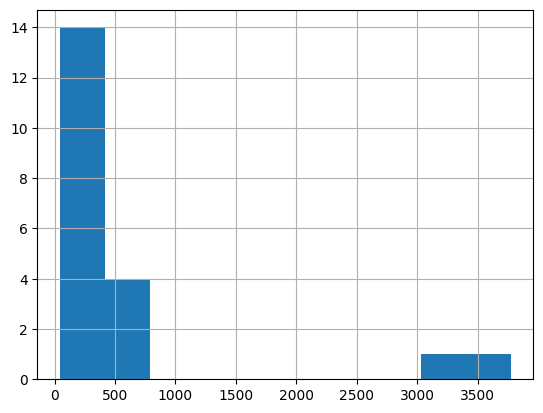

In [6]:
df["comment_text"].map(len).hist()

In [7]:
df = df.drop(df[df["comment_text"].map(len) > 1000].index)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, 0 to 18
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              18 non-null     int64 
 1   comment_text    18 non-null     object
 2   conspiratorial  18 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 576.0+ bytes


## Costruzione di train e test set

In [9]:
X = df["comment_text"]
y = df["conspiratorial"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25, random_state = 10)

In [11]:
tfhub_handle_encoder = "https://tfhub.dev/jeongukjae/smaller_LaBSE_15lang/1"
tfhub_handle_preprocess = "https://tfhub.dev/jeongukjae/smaller_LaBSE_15lang_preprocess/1"

In [12]:
def build_classifier_model():
    # defining inputs
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    # defining preprocessing
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    
    # defining encoder
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    
    # defining outputs
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    
    # Reshape net to add a time step dimension
    net = tf.expand_dims(net, axis=1)
    
    net = tf.keras.layers.LSTM(1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    
    return tf.keras.Model(text_input, net)


In [13]:
classifier_model = build_classifier_model()

2023-05-25 17:48:48.265623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-25 17:48:48.266077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-25 17:48:48.266173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-25 17:48:48.266531: I tensorflow/core/

2023-05-25 17:48:49.522087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string and shape [?]
	 [[{{node inputs}}]]
2023-05-25 17:48:49.539775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]
2023-05-25 17:48:53.466197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [?,128]
	 [[{{node inputs}}]]
2023-05-25 1

In [14]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [15]:
tf.keras.utils.plot_model(classifier_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [17]:
optimizer = Adam(learning_rate=1e-04, epsilon=1e-08,clipnorm=1.0)

classifier_model.compile(
    optimizer=optimizer,
    loss = 'binary_crossentropy', 
    metrics = 'accuracy'
)

In [18]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(
    x = X_train,
    y = y_train, 
    epochs=5, 
    validation_split = 0.25, 
    batch_size = 64, 
    callbacks= [ 
        EarlyStopping( monitor='val_accuracy' ,mode='max', patience=3,verbose=False,restore_best_weights=True)
    ]
)


Training model with https://tfhub.dev/jeongukjae/smaller_LaBSE_15lang/1
Epoch 1/5


2023-05-25 17:48:53.978569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [?,128]
	 [[{{node inputs}}]]
2023-05-25 17:48:53.978720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_2' with dtype int32 and shape [?,128]
	 [[{{node inputs_2}}]]
2023-05-25 17:48:54.220388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node 

2023-05-25 17:48:57.562184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3' with dtype float and shape [?,?,768]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3}}]]
2023-05-25 17:48:57.562283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_4' with dtype float and shape [?,?,768]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_4}}]]
2023-05-25 17:48:57.562326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) 

2023-05-25 17:48:58.395369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3' with dtype float and shape [?,?,768]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3}}]]
2023-05-25 17:48:58.395473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_4' with dtype float and shape [?,?,768]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_4}}]]
2023-05-25 17:48:58.395519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) 

2023-05-25 17:49:02.786849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 17:49:02.788104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 17:49:02.789033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - ETA: 0s - loss: 10.6512 - accuracy: 0.2222

2023-05-25 17:49:20.427183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 17:49:20.428437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 17:49:20.429161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 29s 29s/step - loss: 10.6512 - accuracy: 0.2222 - val_loss: 1.0449 - val_accuracy: 0.5000
Epoch 2/5
1/1 [==============================] - 8s 8s/step - loss: 1.2709 - accuracy: 0.2222 - val_loss: 0.6807 - val_accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 8s 8s/step - loss: 0.6687 - accuracy: 0.3333 - val_loss: 0.6629 - val_accuracy: 0.2500
Epoch 4/5
1/1 [==============================] - 9s 9s/step - loss: 0.6230 - accuracy: 1.0000 - val_loss: 0.6672 - val_accuracy: 0.7500
Epoch 5/5
1/1 [==============================] - 8s 8s/step - loss: 0.6031 - accuracy: 1.0000 - val_loss: 0.6613 - val_accuracy: 0.7500


# vecchio codice

## Tokenizzazione con autotoken

In [11]:
max_length = df["comment_text"].map(len).max()
max_length = max_lenght if max_length < 100 else 100

In [12]:
pretrained_tokenizer = 'dbmdz/bert-base-italian-uncased'

In [13]:
from transformers import AutoTokenizer

def tokenize(X):
    X = tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = max_length,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

tokenizer = AutoTokenizer.from_pretrained(pretrained_tokenizer)

In [14]:
X_train_tokens = tokenize(X_train)
X_test_tokens = tokenize(X_test)

In [52]:
X_train_tokens

{'input_ids': <tf.Tensor: shape=(13, 100), dtype=int32, numpy=
array([[  102,  5752,  4814, ...,   101,   103,     0],
       [  102,   101,  4013, ...,     0,     0,     0],
       [  102,   152, 10096, ...,   377,  5102,   103],
       ...,
       [  102,   172,  1481, ...,     0,     0,     0],
       [  102,   135,  1467, ...,     0,     0,     0],
       [  102,   152,  5120, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(13, 100), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

## Creazione modello

In [57]:
pretrained_embeddings = 'dbmdz/bert-base-italian-uncased'
embeddings_model = TFBertModel.from_pretrained(pretrained_embeddings)

Some layers from the model checkpoint at dbmdz/bert-base-italian-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at dbmdz/bert-base-italian-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [68]:
def get_model():
    # inputs
    input_ids = Input(shape = (max_length,), dtype = tf.int32, name = 'input_ids')
    input_mask = Input(shape = (max_length,), dtype = tf.int32, name = 'input_mask')
    
    # embeddings
    embeddings = embeddings_model([input_ids, input_mask])[1] #pooler output
    
    # dropout layer
    out = Dropout(0.2)(embeddings)
    #print(out.shape)
    #8 units dense layer
    #out = Dense(8,activation = 'relu')(out)
    # LSTM layer
    out = LSTM(units=8, activation = "relu")(out)
    
    # output layer
    y = Dense(1,activation = 'sigmoid')(out)
    
    model = Model(inputs=[input_ids, input_mask], outputs=y)
    #model.layers[2].trainable = False
    
    #define optimizer
    optimizer = Adam(learning_rate=1e-05, epsilon=1e-08,clipnorm=1.0)
    
    #complile the model
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')
    
    return model

In [69]:
model = get_model()
model.summary()

ValueError: Input 0 of layer "lstm_7" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 768)

In [41]:
epochs = 5
validation_split = 0.25
batch_size = 64

In [42]:
history = model.fit(
    x = {
        'input_ids': X_train_tokens['input_ids'],
        'input_mask':X_train_tokens['attention_mask']
    }, 
    y = y_train, 
    epochs=epochs, 
    validation_split = validation_split, 
    batch_size = batch_size, 
    callbacks= [ 
        EarlyStopping( monitor='val_accuracy' ,mode='max', patience=3,verbose=False,restore_best_weights=True)
    ]
)

Epoch 1/5
1/1 [==============================] - 14s 14s/step - loss: 0.6941 - accuracy: 0.7778 - val_loss: 0.7433 - val_accuracy: 0.5000
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 0.5828 - accuracy: 0.7778 - val_loss: 0.7433 - val_accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 2s 2s/step - loss: 0.6247 - accuracy: 0.7778 - val_loss: 0.7433 - val_accuracy: 0.5000
Epoch 4/5
1/1 [==============================] - 3s 3s/step - loss: 0.6235 - accuracy: 0.6667 - val_loss: 0.7433 - val_accuracy: 0.5000


## Test phase

In [40]:
y_prediction = model.predict(
    x = {
        'input_ids': X_test_tokens['input_ids'],
        'input_mask':X_test_tokens['attention_mask']
    }
)

1/1 [==============================] - 0s 478ms/step


In [53]:
y_prediction

array([[0.43037605],
       [0.46875182],
       [0.5112577 ],
       [0.5804879 ]], dtype=float32)

In [59]:
y_prediction_labels = np.array([ [round(_[0])] for _ in y_prediction])    

## Evaluation

In [73]:
result = confusion_matrix(y_test, y_prediction_labels)

In [74]:
result

array([[1, 0],
       [1, 2]])